# Split Area Of Interest into tiles

The area of interest (AOI) at a country level is too large and needs to be tiled into smaller
pieces in order to be able to fit the one-year-long time series into memory. 
Each piece is called an `EOPatch` in the `eo-learn` package. In order to create an 
`EOPatch` we simply need the bounding box in a given coordinate reference system. We'll
use `BBOXSplitter` from [`sentinelhub`](https://github.com/sentinel-hub/sentinelhub-py) python package.

Each BBOX will later on be used do define an EOPatch.

---

This notebook performs the following actions:

1. Take buffered country
    * the defintion of Slovenia was taken from [here](http://www.naturalearthdata.com/downloads/10m-cultural-vectors/) and buffered a little bit 
2. Convert it to selected CRS
    * taken to be the CRS of central UTM tile (UTM_33N)
3. Tile it into non-overlaping BBOXes
    * use `BBoxSplitter` from `sentinelhub` package
    * tile the buffered Slovenia into non-overlapping rectangular regions 
    * each rectangular region defines a BBOX
4. Visualise the splitting
5. Store the BBOXes to disk
    * pickled list 
    * geopandas dataframe

In [30]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import BBoxSplitter, BBox, CRS, DataSource, transform_bbox

In [32]:
from pathlib import Path

In [33]:
import geopandas
import pandas as pd

In [34]:
data = Path('./')

#### Selected CRS

In [35]:
country_crs = CRS.UTM_33N

## Load AOI 

In this example it is buffered outline of Slovenia.

In [36]:
country = geopandas.read_file(str(data/'reference-data'/'slovenia-def'/'svn_buffered.geojson'))

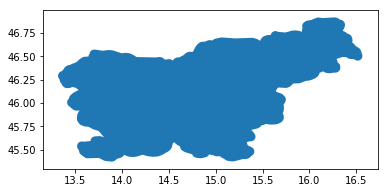

In [37]:
country.plot()

In [38]:
country.crs

{'init': 'epsg:4326'}

Reproject to selected CRS:

In [39]:
country = country.to_crs(crs={'init':CRS.ogc_string(country_crs)})

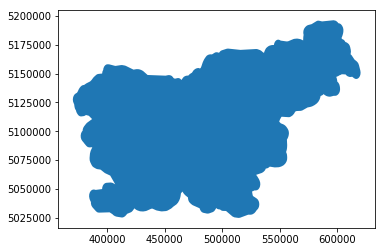

In [40]:
country.plot()

In [41]:
country.crs

{'init': 'EPSG:32633'}

Get the polygon of AOI

In [42]:
country_shape = country.geometry.values.tolist()[-1]

### Estimate the size of Area Of Interest (= Slovenia)

In [43]:
country_shape.bounds

(370230.5261411405, 5024718.807260214, 620100.3316429297, 5196374.997444821)

In [44]:
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2]-country_shape.bounds[0],country_shape.bounds[3]-country_shape.bounds[1]))

Dimension of the area is 249870 x 171656 m2


In [45]:
width_pix = int((country_shape.bounds[2]-country_shape.bounds[0])/10)
height_pix = int((country_shape.bounds[3]-country_shape.bounds[1])/10)

In [46]:
print('Dimension of the area is {} x {} pixels'.format(width_pix, height_pix))

Dimension of the area is 24986 x 17165 pixels


# Perform tiling = get list of BBOXes

The AOI will be tiled in 25 (columns) x 17 (rows). The number of columns and tiles is selected in a way so that each EOPatch will have around 1000 x 1000 pixels at 10 meter resolution.

In [47]:
bbox_splitter = BBoxSplitter([country_shape], country_crs, (25, 17))  

In [48]:
print('Area bounding box: {}\n'.format(bbox_splitter.get_area_bbox().__repr__()))

Area bounding box: BBox(((370230.5261411405, 5024718.807260214), (620100.3316429297, 5196374.997444821)), crs=EPSG:32633)



In [49]:
bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

print('Each bounding box also has some info how it was created. Example:\n'
      '\nbbox: {}\ninfo: {}\n'.format(bbox_list[0].__repr__(), info_list[0]))

Each bounding box also has some info how it was created. Example:

bbox: BBox(((370230.5261411405, 5085303.344972428), (380225.31836121203, 5095400.767924464)), crs=EPSG:32633)
info: {'parent_bbox': BBox(((370230.5261411405, 5024718.807260214), (620100.3316429297, 5196374.997444821)), crs=EPSG:32633), 'index_x': 0, 'index_y': 6}



The total number of tiles is:

In [50]:
len(bbox_splitter.bbox_list)

293

### Save the splitter to pickle file for later use

In [51]:
import pickle

In [52]:
with open(data/'reference-data'/'tile-def'/'slovenia_buffered_bbox_32633_17x25_293.pickle','wb') as fp:
    pickle.dump(bbox_splitter, fp)

## Visualise the tiling

### Convert to geopandas dataframe

In [53]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

In [54]:
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.bbox_list]
idxs_x = [info['index_x'] for info in bbox_splitter.info_list]
idxs_y = [info['index_y'] for info in bbox_splitter.info_list]

df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
gdf = gpd.GeoDataFrame(df, crs={'init':CRS.ogc_string(bbox_splitter.bbox_list[0].crs)}, geometry=geometry)

In [59]:
gdf.head()

,index_x,index_y,geometry
0,0,6,"POLYGON ((370230.5261411405 5085303.344972428,..."
1,0,7,"POLYGON ((370230.5261411405 5095400.767924464,..."
2,0,8,"POLYGON ((370230.5261411405 5105498.1908765, 3..."
3,0,9,"POLYGON ((370230.5261411405 5115595.613828535,..."
4,0,10,"POLYGON ((370230.5261411405 5125693.036780571,..."


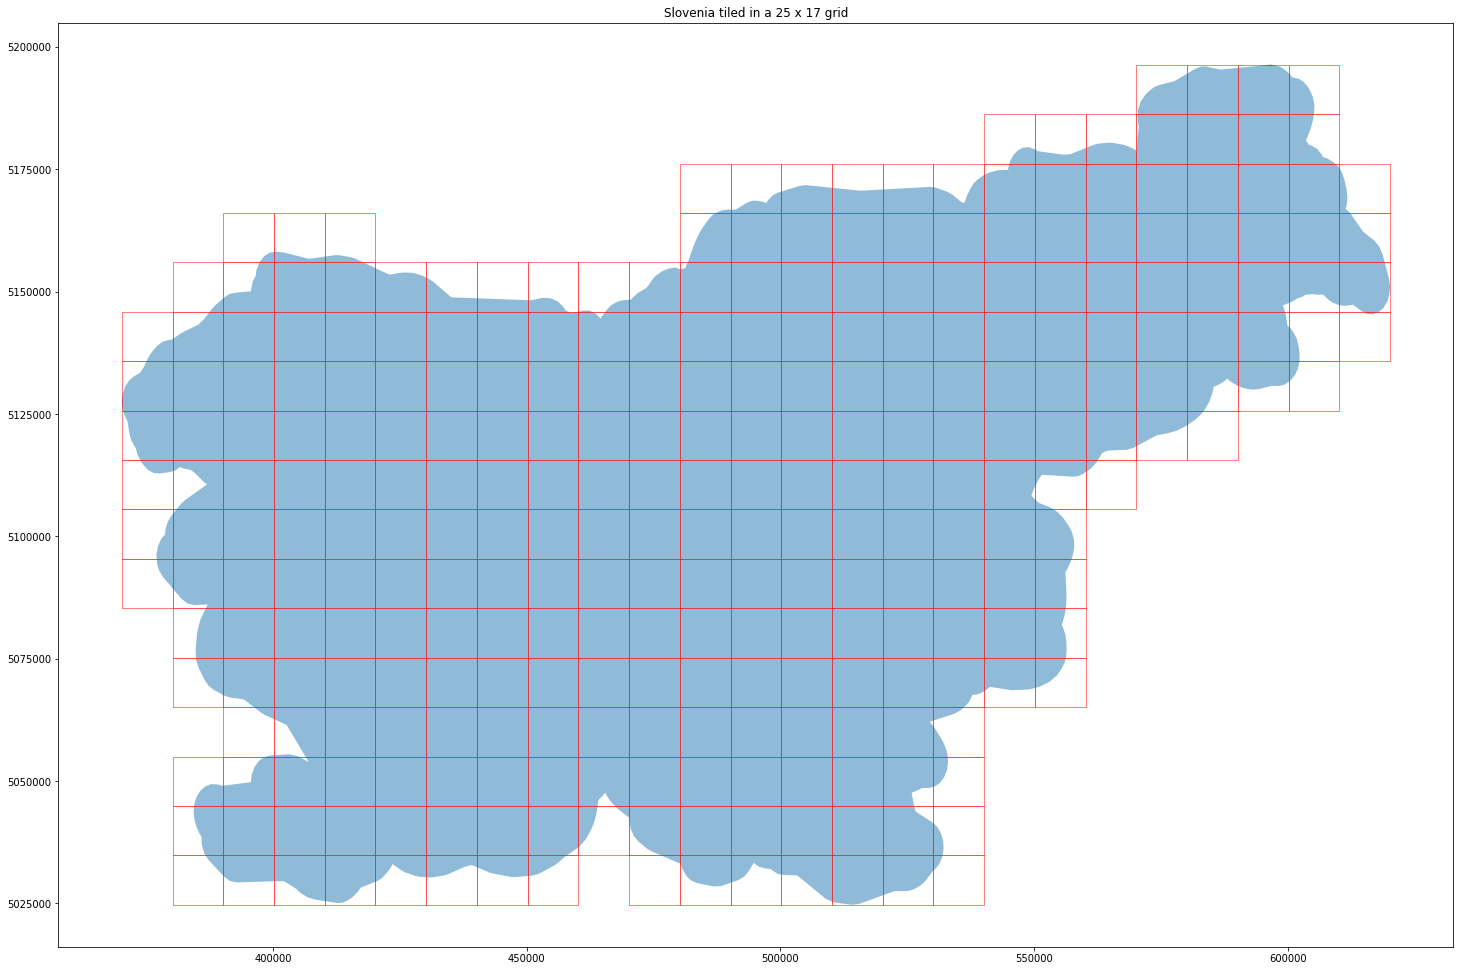

In [60]:
fig, ax = plt.subplots(1, figsize=(25,17))
ax = country.plot(ax=ax)
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
ax.set_title('Slovenia tiled in a 25 x 17 grid');
fig.savefig(data/'figs'/'aoi_to_tiles.png', bbox_inches='tight')

In [61]:
gdf.to_file(str(data/'reference-data'/'tile-def'/'country_buffered_bbox_32633_17x25_293.shp'))